### import 진행하여 필요한 라이브러리를 설치한다.

In [225]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

### 예시로 사용할 torchvision의 FashionMNIST를 불러옵니다.

In [226]:
train_data = datasets.FashionMNIST(
    root = 'data',
    download= True,
    train= True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root = 'data',
    download= True,
    train = False,
    transform= ToTensor()
)

### 예시로 불러온 FashionMNIST를 시각화 해봅니다.

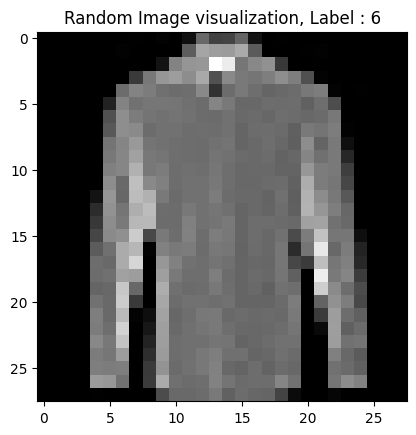

In [227]:
import matplotlib.pyplot as plt 
import random 

# train_data는 x,y를 반환하며 x에는 이미지, y에는 해당 라벨이 들어있습니다.
idx = random.randint(0, len(train_data))
X, y = train_data[idx]

# 현재 이미지의 경우 흑백이미지 이기에 (1, 28, 28 ) 을 squeeze()를 진행하여 (28, 28)로 만들어서 시각화 해줍니다.
plt.imshow(X.squeeze(), cmap = 'gray')
plt.title(f'Random Image visualization, Label : {y}')
plt.show()

### 데이터를 iteration 하게 불러올 수 있도록 DataLoader를 구현합니다.

In [228]:
train_dataloader = DataLoader(train_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

# DataLoader가 데이터를 어떻게 불러오는지 확인합니다.
train_laoder_result = next(iter(train_dataloader))
# print(train_laoder_result)
iamges, labels = train_laoder_result
print(f'TrainLoader에서 불러오는 이미지들의 shape :  {iamges.shape}')
print(f'TrainLoader에서 불러오는 라벨들의 shape :  {labels.shape}')

TrainLoader에서 불러오는 이미지들의 shape :  torch.Size([64, 1, 28, 28])
TrainLoader에서 불러오는 라벨들의 shape :  torch.Size([64])


### 데이터를 학습 시킬 모델을 직접 구현합니다.

In [229]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding = 1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, kernel_size=3, padding = 1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(7 * 7 * 64, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10)

        )

    def forward(self, x):
        conv_result = self.conv_layer(x)
        flatten = conv_result.view(-1, 7 * 7 * 64,)
        result = self.fc_layer(flatten)
        return result



In [230]:
model = CustomModel()
print(model)

CustomModel(
  (conv_layer): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


### Loss fucntion과 optimizer를 선언합니다.

In [231]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### train 함수를 작성합니다.

In [233]:
import tqdm
from prettytable import PrettyTable


def visualization(train_image, pred, y):
    fig, axs = plt.subplots(1, 3, figsize = (15, 5))
    for i, ax in enumerate(axs):
        img = train_image[i].squeeze()
        ax.imshow(img, cmap = 'gray')
        ax.set_title(f'Pred : {pred[i]}, Label : {y[i]}')
        ax.axis('off')
    plt.show()
        



def train(data_loader, model, loss_fn, optimizer, device, eph):
    model.train()
    total_loss = 0
    visual_idx = [random.randint(0, len(data_loader)-1) for _ in range(3)]
    
    visual_iamge = []
    visual_pred = []
    visual_label = []


    for idx, (X, y) in enumerate(tqdm.tqdm(data_loader, desc = 'Training')):
        X , y = X.to(device), y.to(device)
        pred = model(X)

        if idx in visual_idx:
            visual_iamge.append(X[0])
            visual_pred.append(pred[0].argmax().item())
            visual_label.append(y[0].item())

        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    visualization(visual_iamge, visual_pred, visual_label)

    table = PrettyTable()
    table.field_names = ['EPOCH', 'Average Loss']
    table.add_row([f'{eph + 1}', f'{total_loss / len(data_loader)}'])
    print(table)

    

### Test 함수를 작성합니다.

In [234]:
def test(data_loader, model, loss_fn, device):
    model.eval()
    total_loss, correct = 0, 0
    num_sample = 0

    for X, y in tqdm.tqdm(data_loader, desc='Testing'):
        X,y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        total_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        num_sample += y.size(0)
    
    avg_loss = total_loss / len(data_loader)
    avg_accuracy = correct / num_sample * 100
    table = PrettyTable()
    table.field_names = ["Metric", "Value"]
    table.add_row(["Average loss in evaluation", f"{avg_loss:.4f}"])
    table.add_row(["Average accuracy in evaluation", f"{avg_accuracy:.2f} %"])

    print(table)

### Epoch을 설정하고 학습을 진행합니다.

EPOCH : [ 1 | 5]


Training: 100%|██████████| 938/938 [00:26<00:00, 35.63it/s]


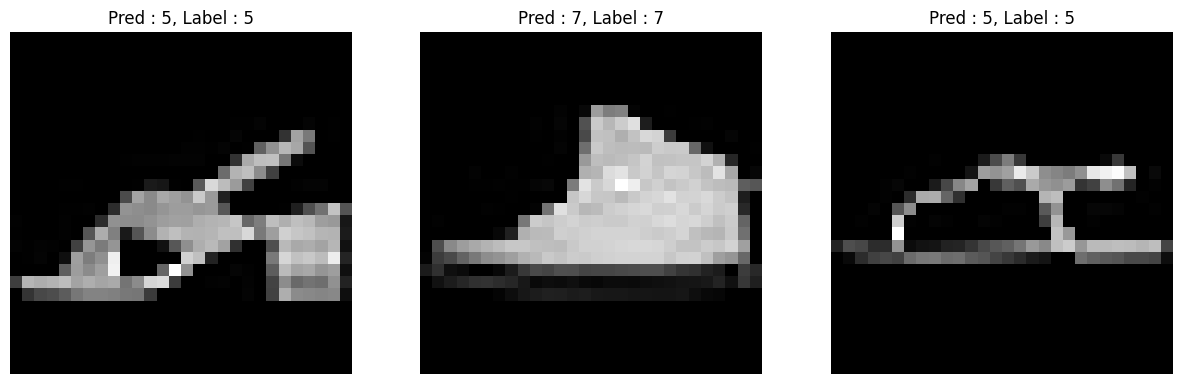

+-------+--------------------+
| EPOCH |    Average Loss    |
+-------+--------------------+
|   1   | 0.4402845248278143 |
+-------+--------------------+


Testing: 100%|██████████| 157/157 [00:01<00:00, 109.92it/s]


+--------------------------------+---------+
|             Metric             |  Value  |
+--------------------------------+---------+
|   Average loss in evaluation   |  0.3539 |
| Average accuracy in evaluation | 87.12 % |
+--------------------------------+---------+
EPOCH : [ 2 | 5]


Training: 100%|██████████| 938/938 [00:25<00:00, 36.51it/s]


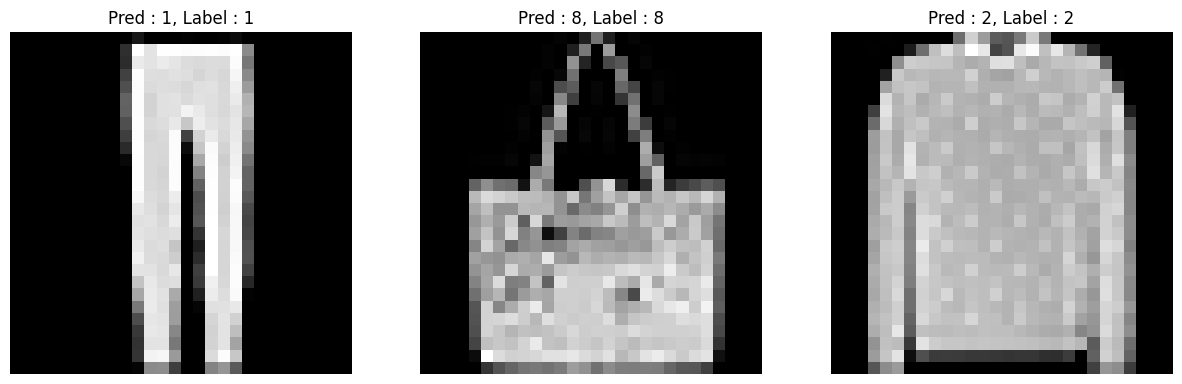

+-------+---------------------+
| EPOCH |     Average Loss    |
+-------+---------------------+
|   2   | 0.28014859811329385 |
+-------+---------------------+


Testing: 100%|██████████| 157/157 [00:01<00:00, 112.68it/s]


+--------------------------------+---------+
|             Metric             |  Value  |
+--------------------------------+---------+
|   Average loss in evaluation   |  0.3309 |
| Average accuracy in evaluation | 88.10 % |
+--------------------------------+---------+
EPOCH : [ 3 | 5]


Training: 100%|██████████| 938/938 [00:26<00:00, 34.95it/s]


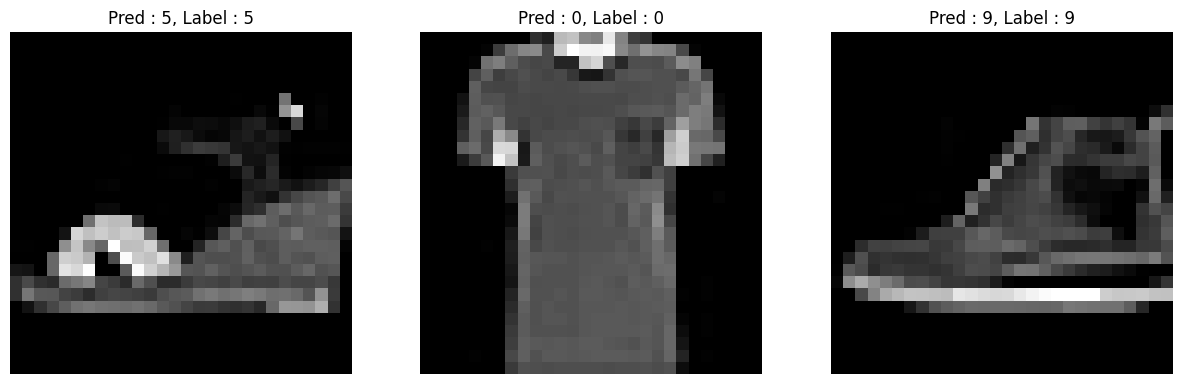

+-------+---------------------+
| EPOCH |     Average Loss    |
+-------+---------------------+
|   3   | 0.23928364274947883 |
+-------+---------------------+


Testing: 100%|██████████| 157/157 [00:01<00:00, 107.71it/s]


+--------------------------------+---------+
|             Metric             |  Value  |
+--------------------------------+---------+
|   Average loss in evaluation   |  0.3132 |
| Average accuracy in evaluation | 89.00 % |
+--------------------------------+---------+
EPOCH : [ 4 | 5]


Training: 100%|██████████| 938/938 [00:26<00:00, 35.68it/s]


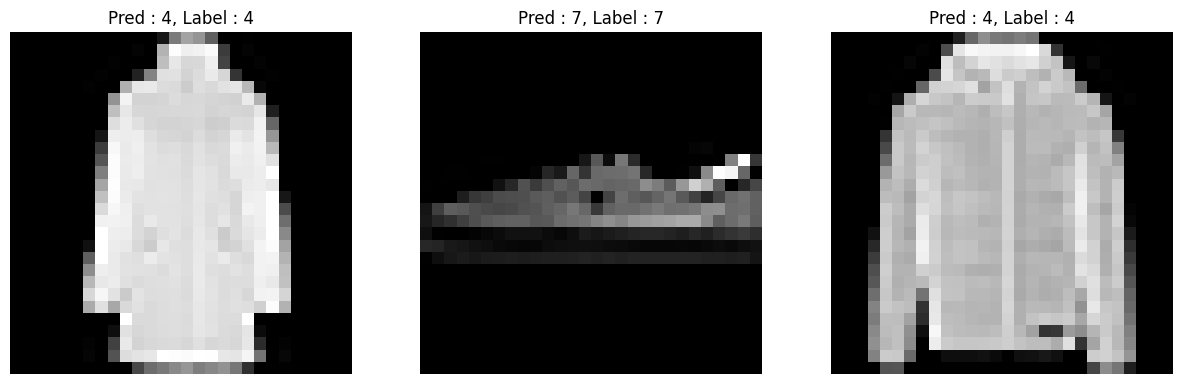

+-------+--------------------+
| EPOCH |    Average Loss    |
+-------+--------------------+
|   4   | 0.2110282435719329 |
+-------+--------------------+


Testing: 100%|██████████| 157/157 [00:01<00:00, 103.65it/s]


+--------------------------------+---------+
|             Metric             |  Value  |
+--------------------------------+---------+
|   Average loss in evaluation   |  0.3053 |
| Average accuracy in evaluation | 89.16 % |
+--------------------------------+---------+
EPOCH : [ 5 | 5]


Training: 100%|██████████| 938/938 [00:28<00:00, 32.66it/s]


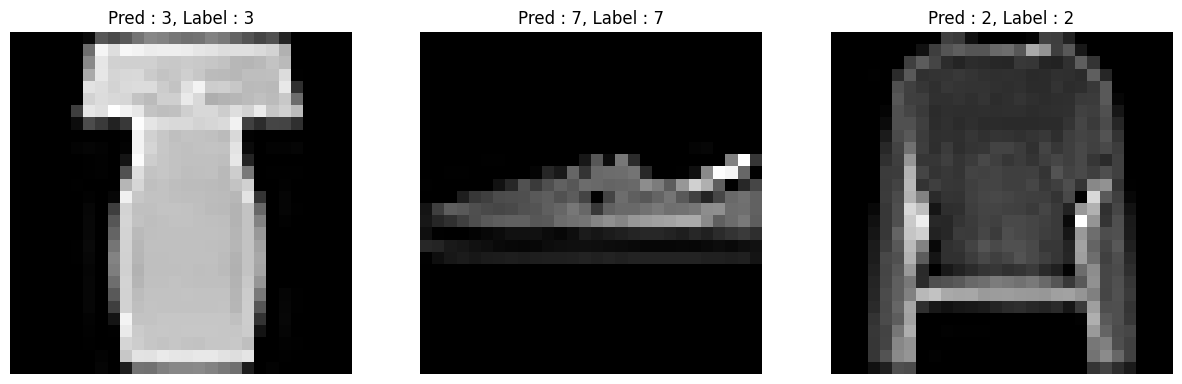

+-------+--------------------+
| EPOCH |    Average Loss    |
+-------+--------------------+
|   5   | 0.1884521640289122 |
+-------+--------------------+


Testing: 100%|██████████| 157/157 [00:01<00:00, 81.07it/s]

+--------------------------------+---------+
|             Metric             |  Value  |
+--------------------------------+---------+
|   Average loss in evaluation   |  0.3003 |
| Average accuracy in evaluation | 89.32 % |
+--------------------------------+---------+
DONE


In [235]:
epoch = 5

for eph in range(epoch):
    print(f'EPOCH : [ {eph + 1} | {epoch}]')
    train(train_dataloader, model, loss_fn, optimizer, device, eph)
    test(test_dataloader, model, loss_fn, device)
print('DONE')